In [34]:
import tensorflow as tf
from tensorflow.keras import layers
import os

print(tf.VERSION)
print(tf.__version__)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

1.10.0
1.10.0


In [35]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images

from skimage.measure import compare_psnr, compare_ssim


from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [36]:
# Set some parameters
im_width = 896
im_height = 448
border = 5
path_train = 'train/'
path_test = 'test/'

In [37]:
def get_data(path, train=True):
    ids = next(os.walk(path + "raw"))[2]
    
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load raw
        img = load_img(path + 'raw/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (448,896, 1), mode='constant', preserve_range=True)

        # Load average
        if train:
            average = img_to_array(load_img(path + 'average/' + id_, grayscale=True))
            average = resize(average, (448, 896, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = average / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


A Jupyter Widget

/home/rupali/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.01, random_state=2018)

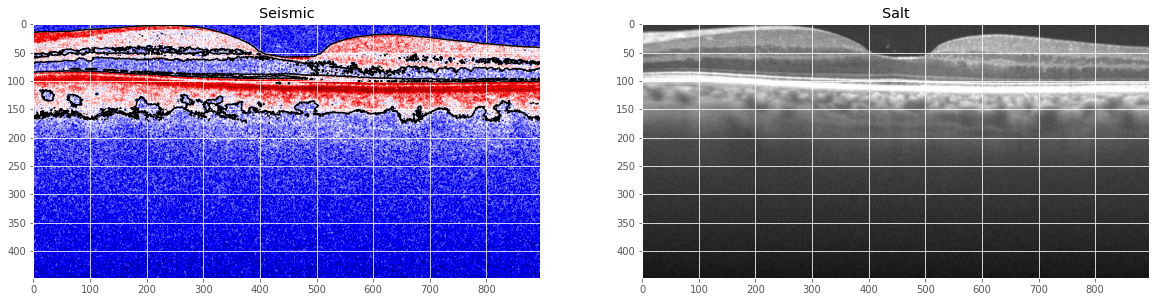

In [39]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [40]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [41]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [42]:
def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return Model(input=inputs, output=path)

In [43]:
input_img = Input((im_height, im_width, 1), name='img')
#model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)



model = build_res_unet((im_height, im_width, 1))

model.compile(optimizer=Adam(), loss="mse", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 448, 896, 1)  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 448, 896, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 448, 896, 64) 256         conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 448, 896, 64) 128         input_3[0][0]                    
__________________________________________________________________________________________________
activation

/home/rupali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [44]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [45]:
results = model.fit(X_train, y_train, batch_size=1, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 39 samples, validate on 1 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[1,768,112,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: batch_normalization_52/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, _class=["loc:@train...chNormGrad"], data_format="NCHW", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](concatenate_7/concat, batch_normalization_52/gamma/read, batch_normalization_52/beta/read, batch_normalization_60/Const_4, batch_normalization_60/Const_4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_2/mul/_993 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7605_loss_2/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


NameError: name 'results' is not defined

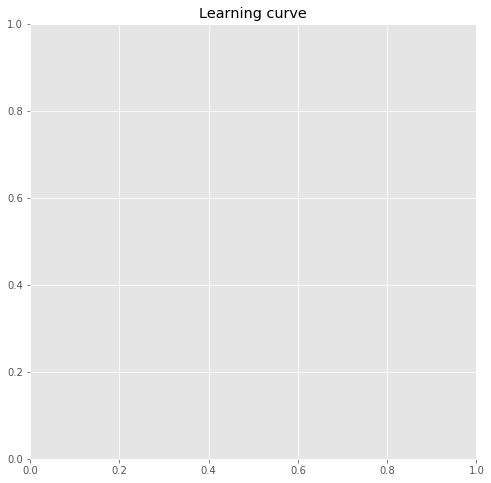

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [18]:
model.load_weights('model-tgs-salt.h5')
#model.load_weights('model-full.h5')

In [11]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 4s 4s/step


[0.0012439554557204247, 0.0]

In [12]:
# Predict on train, val and test
#preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
#preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 1s 791ms/step


In [13]:
def get_test_data(path, test=True):
    ids = next(os.walk(path + "raw"))[2]
    
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if test:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load raw
        img = load_img(path + 'raw/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 512, 1), mode='constant', preserve_range=True)

        # Load average
        if test:
            average = img_to_array(load_img(path + 'average/' + id_, grayscale=True))
            average = resize(average, (256, 512, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if test:
            y[n] = average / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X_test, y_test = get_data(path_test, train=True)

Getting and resizing images ... 


A Jupyter Widget


Done!


/home/rupali/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [19]:
model.evaluate(X_test, y_test, verbose=1)
preds_test = model.predict(X_test, verbose=1)

4/4 [==============================] - 1s 164ms/step


In [15]:
print(X_test.shape)
print(preds_test.shape)

(4, 512, 896, 1)
(4, 512, 896, 1)


In [21]:
import scipy.misc
scipy.misc.imsave('20_epoch/i1.png',preds_test[0,:,:,0])
scipy.misc.imsave('20_epoch/i2.png',preds_test[1,:,:,0])
scipy.misc.imsave('20_epoch/i3.png',preds_test[2,:,:,0])
scipy.misc.imsave('20_epoch/i4.png',preds_test[3,:,:,0])

In [22]:
p1 = compare_psnr(X_test[0,:,:,0],preds_test[0,:,:,0])
p2 = compare_psnr(X_test[1,:,:,0],preds_test[1,:,:,0])
p3 = compare_psnr(X_test[2,:,:,0],preds_test[2,:,:,0])
p4 = compare_psnr(X_test[3,:,:,0],preds_test[3,:,:,0])

print(p1,p2,p3,p4)

21.46997108063797 21.305945970317595 21.310897676146894 20.614296649136943
